# Deep Learning Project 3 - Computer Vision Multi-Classification and                                                                  Multi-Layer Convolutional Neural Network Model

Previously, pickle files were formatted datasets for training, development and testing on the notMNIST dataset.
The goal of this project is to train a convolutional neural network model using TensorFlow with mini-batch learning, one(1) channel, three(3) layers [two(2) convoluational; one(1) fully connected], depth of 5, and 5 by 5 patch filter size.

In [1]:
# Import required modules 
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

C:\Users\trevo\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Reload the pre-processed datasets that was generated previously
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  rand_sanit_dataset = save['rand_sanit_dataset']
  rand_sanit_labels = save['rand_sanit_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Random Sanitized Training set', rand_sanit_dataset.shape, rand_sanit_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Random Sanitized Training set (195307, 28, 28) (195307,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape: convolutions need the image data formatted as a cube (width by height by #channels) and labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale


def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  # 1-hot encodings for classifier labels
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  # labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  # Alternate 1-hot encodings implementation
  # Establish np array based on the size (shape) of the label dataset and the number of classification labels
  # .shape returns shape tuple object; .shape[] returns shape integer values
  label_one_hot_array = np.zeros((labels.shape[0],num_labels))
  # Set the np array location value to one (1) based on the label classifer value
  label_one_hot_array[np.arange(labels.shape[0]),labels]=1.0
  # Update labels np array with one_hot_encoding array
  labels = label_one_hot_array
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
rand_sanit_dataset, rand_sanit_labels = reformat(rand_sanit_dataset, rand_sanit_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Random Sanitized Training set', rand_sanit_dataset.shape, rand_sanit_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Random Sanitized Training set (195307, 28, 28, 1) (195307, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Building a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally; therefore, limiting its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
learning_rate = 0.05

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables for layer weights and biases.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(tf.nn.bias_add(conv, layer1_biases))
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(tf.nn.bias_add(conv,layer2_biases))
    # Tranform last hidden convolutional layer to be flat for fully connected last layer
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.add(tf.matmul(hidden, layer4_weights),layer4_biases)
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Execute tensorflow graph sessions

In [6]:
"""Train CNN algorithm with unsanitized dataset (duplicate images between training and validation/test datasets)"""

# Clear previous graph session
ops.reset_default_graph()

# Declare variable to train model over 1000 iterations
num_steps = 1001

# Define loss and training accuracy lists variables
loss_vec_list = []
train_acc_list = []
validation_acc_list = []


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Establish mini-batch datasets from unsanitized training datasets
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Define data feed dictionary for tensorflow placeholders
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    # Run graph session for model optimizer, loss, and train prediction functions
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    # Save generation loss value in list
    loss_vec_list.append(l)
    
    # Display training and validation accuracy performance every 50 generations
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      train_acc_temp = accuracy(predictions, batch_labels)
      train_acc_list.append(train_acc_temp)
      print('Minibatch training accuracy: %.1f%%' % train_acc_temp)
      validation_acc_temp = accuracy( valid_prediction.eval(), valid_labels)
      validation_acc_list.append(validation_acc_temp)
      print('Validation accuracy: %.1f%%' % validation_acc_temp)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.914614
Minibatch training accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.168609
Minibatch training accuracy: 68.8%
Validation accuracy: 66.3%
Minibatch loss at step 100: 0.961234
Minibatch training accuracy: 68.8%
Validation accuracy: 74.2%
Minibatch loss at step 150: 0.500771
Minibatch training accuracy: 81.2%
Validation accuracy: 75.3%
Minibatch loss at step 200: 0.906229
Minibatch training accuracy: 68.8%
Validation accuracy: 78.1%
Minibatch loss at step 250: 1.029597
Minibatch training accuracy: 68.8%
Validation accuracy: 77.3%
Minibatch loss at step 300: 0.345252
Minibatch training accuracy: 87.5%
Validation accuracy: 78.4%
Minibatch loss at step 350: 0.563131
Minibatch training accuracy: 93.8%
Validation accuracy: 78.0%
Minibatch loss at step 400: 0.223003
Minibatch training accuracy: 93.8%
Validation accuracy: 79.8%
Minibatch loss at step 450: 0.824550
Minibatch training accuracy: 87.5%
Validation accuracy: 80.1%
Mi

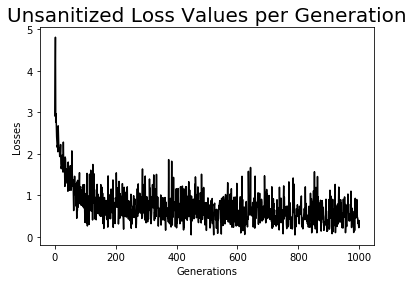

In [7]:
"""Visualize model loss values"""

#Plot Losses
plt.plot(loss_vec_list, 'k-')
plt.title('Unsanitized Loss Values per Generation', fontsize = 20)
plt.xlabel('Generations')
plt.ylabel('Losses')
plt.show()

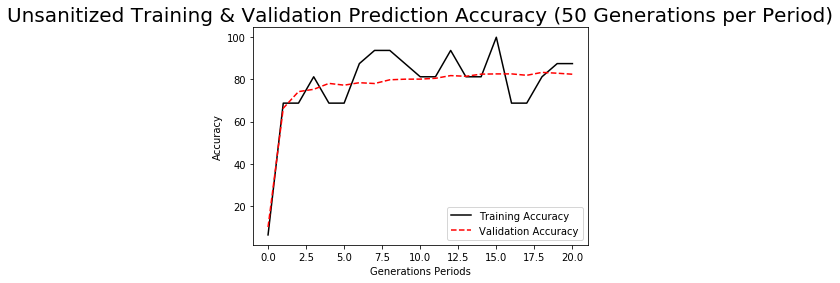

In [8]:
"""Visualize training and validation prediction accuracy"""

#Plot Losses
plt.plot(train_acc_list, 'k-', label = 'Training Accuracy')
plt.plot(validation_acc_list, 'r--', label = 'Validation Accuracy')
plt.title('Unsanitized Training & Validation Prediction Accuracy (50 Generations per Period)', fontsize = 20)
plt.xlabel('Generations Periods')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.show()

In [9]:
"""Train CNN algorithm with sanitized dataset (no duplicate images between training and validation/test datasets)"""

# Clear previous graph session
ops.reset_default_graph()

# Train model over 1000 iterations
num_steps = 1001

# Define loss and training accuracy lists variables
sanitized_loss_vec_list = []
sanitized_train_acc_list = []
sanitized_validation_acc_list = []

# rand_sanit_dataset rand_sanit_labels
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Establish mini-batch datasets from sanitized training datasets
    offset = (step * batch_size) % (rand_sanit_labels.shape[0] - batch_size)
    batch_data = rand_sanit_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = rand_sanit_labels[offset:(offset + batch_size), :]
    # Define data feed dictionary for tensorflow placeholders
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    # Run graph session for model optimizer, loss, and train prediction functions
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    # Save generation loss value in list
    sanitized_loss_vec_list.append(l)
    
    # Display training and validation accuracy performance every 50 generations
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      train_acc_temp = accuracy(predictions, batch_labels)
      sanitized_train_acc_list.append(train_acc_temp)
      print('Minibatch training accuracy: %.1f%%' % train_acc_temp)
      validation_acc_temp = accuracy( valid_prediction.eval(), valid_labels)
      sanitized_validation_acc_list.append(validation_acc_temp)
      print('Validation accuracy: %.1f%%' % validation_acc_temp)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.590021
Minibatch training accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 50: 2.048252
Minibatch training accuracy: 31.2%
Validation accuracy: 33.3%
Minibatch loss at step 100: 2.111996
Minibatch training accuracy: 31.2%
Validation accuracy: 56.2%
Minibatch loss at step 150: 0.450196
Minibatch training accuracy: 87.5%
Validation accuracy: 74.4%
Minibatch loss at step 200: 0.972421
Minibatch training accuracy: 75.0%
Validation accuracy: 76.7%
Minibatch loss at step 250: 0.301238
Minibatch training accuracy: 100.0%
Validation accuracy: 74.5%
Minibatch loss at step 300: 0.635157
Minibatch training accuracy: 81.2%
Validation accuracy: 78.6%
Minibatch loss at step 350: 0.863452
Minibatch training accuracy: 75.0%
Validation accuracy: 76.5%
Minibatch loss at step 400: 0.898885
Minibatch training accuracy: 75.0%
Validation accuracy: 79.7%
Minibatch loss at step 450: 0.527453
Minibatch training accuracy: 81.2%
Validation accuracy: 80.1%
M

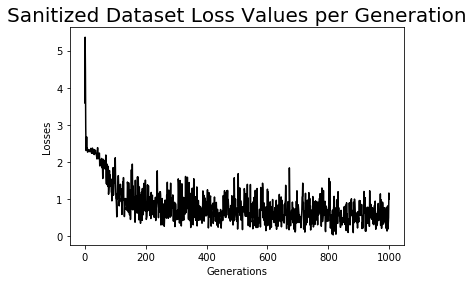

In [10]:
"""Visualize model loss values"""

#Plot Losses
plt.plot(sanitized_loss_vec_list, 'k-')
plt.title('Sanitized Dataset Loss Values per Generation', fontsize = 20)
plt.xlabel('Generations')
plt.ylabel('Losses')
plt.show()

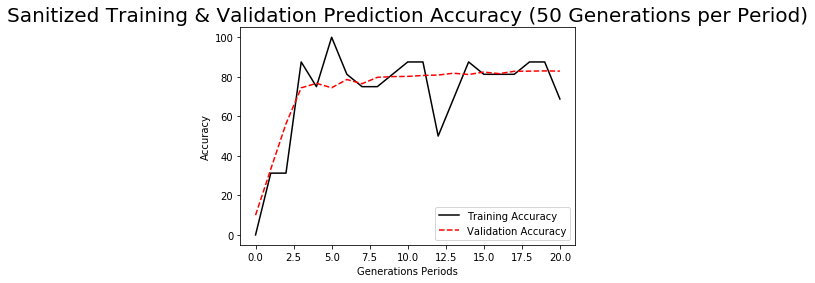

In [11]:
"""Visualize training and validation prediction accuracy"""

#Plot Losses
plt.plot(sanitized_train_acc_list, 'k-', label = 'Training Accuracy')
plt.plot(sanitized_validation_acc_list, 'r--', label = 'Validation Accuracy')
plt.title('Sanitized Training & Validation Prediction Accuracy (50 Generations per Period)', fontsize = 20)
plt.xlabel('Generations Periods')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.show()